In [31]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import pyro
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyro.distributions as dist
import zuko

from bayes_air.utils.zuko2pyro import Zuko2Pyro


sns.set(style="white", context="notebook", palette="deep", color_codes=True)

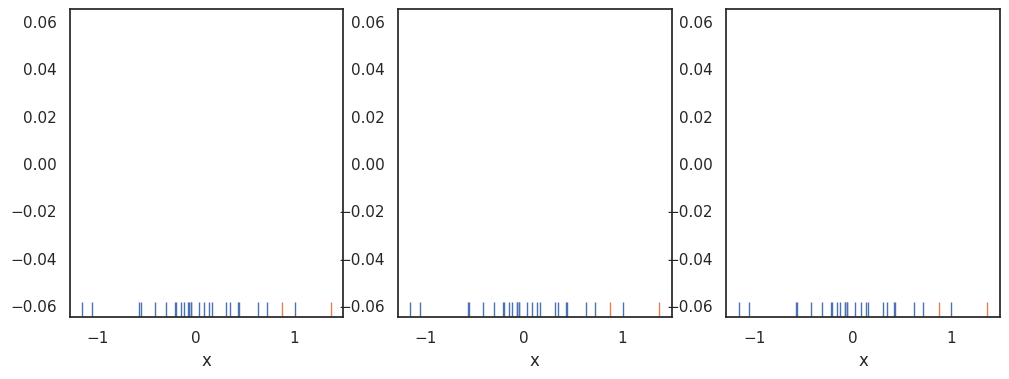

In [32]:
# Generate a bunch of samples from a normal distribution
torch.manual_seed(0)
pyro.set_rng_seed(0)
N_nominal = 25
N_failure = 2
nominal_mean = 0.0
failure_mean = 1.0
std = 0.5

nominal_samples = torch.normal(nominal_mean, std, (N_nominal,))
failure_samples = torch.normal(failure_mean, std, (N_failure,))

df = pd.concat(
    [
        pd.DataFrame({"x": nominal_samples, "type": "nominal"}),
        pd.DataFrame({"x": failure_samples, "type": "failure"}),
    ]
)

fig, axs = plt.subplot_mosaic([["failure_only", "all_data", "gavi"]], figsize=(12, 4))

for ax in axs.values():
    sns.rugplot(x="x", hue="type", data=df, ax=ax, legend=False, height=0.05)

In [33]:
# Define the toy model
def original_model(
    n_samples, x=None, kl_constraint=None
):  # last arg needed for flow-based GAVI
    mean = pyro.sample("mean", dist.Normal(0.0, 100.0))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(0.0, 100.0)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

In [34]:
pyro.clear_param_store()
param_store = pyro.get_param_store()

# These should be reset each training loop.
with param_store.scope() as nominal_auto_guide_state:
    nominal_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, nominal_auto_guide)
    elbo(N_nominal, nominal_samples)
    optim = torch.optim.Adam(elbo.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(N_nominal, nominal_samples)
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    n_posterior_samples = 100_000
    with pyro.plate("samples", n_posterior_samples, dim=-1):
        nominal_posterior_samples = nominal_auto_guide(N_nominal)

# These should be reset each training loop.
with param_store.scope() as failure_auto_guide_state:
    failure_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, failure_auto_guide)
    elbo(N_nominal, nominal_samples)
    optim = torch.optim.Adam(elbo.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(N_failure, failure_samples)
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    with pyro.plate("samples", n_posterior_samples, dim=-1):
        failure_posterior_samples = failure_auto_guide(N_failure)

failure_only_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": failure_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ]
)

In [35]:
# These should be reset each training loop.
with param_store.scope() as nominal_flow_state:
    # Define the flow (features = 2 latent params, context = 1 KL constraint)
    nominal_flow = zuko.flows.NSF(
        features=2, context=1, transforms=1, hidden_features=(256, 256)
    )
    nominal_flow.transform = (
        nominal_flow.transform.inv
    )  # inverse autoregressive flow (IAF) are fast to sample from

    def nominal_flow_guide(n_samples, x=None, kl_constraint=None):
        pyro.module("nominal_flow", nominal_flow)

        if kl_constraint is None:
            kl_constraint = torch.tensor(
                [1.0]
            )  # functionally unconstrained (should be normalized to 0 to 1)

        sample = pyro.sample(
            "sample", Zuko2Pyro(nominal_flow(kl_constraint)), infer={"is_auxiliary": True}
        )

        if sample.ndim > 1:
            mean = pyro.sample("mean", dist.Delta(sample[:, 0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[:, 1]))
            sigma = torch.exp(log_sigma)
        else:
            mean = pyro.sample("mean", dist.Delta(sample[0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[1]))
            sigma = torch.exp(log_sigma)

        return {"mean": mean, "log_sigma": log_sigma}

    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, nominal_flow_guide)
    elbo(N_nominal, nominal_samples, torch.tensor([0.0]))
    optim = torch.optim.Adam(nominal_flow.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(N_nominal, nominal_samples)
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    n_posterior_samples = 100_000
    with pyro.plate("samples", n_posterior_samples, dim=-1):
        nominal_posterior_samples = nominal_flow_guide(N_nominal)

# These should be reset each training loop.
with param_store.scope() as failure_flow_guide_state:
    # Define the flow (features = 2 latent params, context = 1 KL constraint)
    failure_flow = zuko.flows.NSF(
        features=2, context=1, transforms=1, hidden_features=(256, 256)
    )
    failure_flow.transform = (
        failure_flow.transform.inv
    )  # inverse autoregressive flow (IAF) are fast to sample from

    def failure_flow_guide(n_samples, x=None, kl_constraint=None):
        pyro.module("flow", failure_flow)

        if kl_constraint is None:
            kl_constraint = torch.tensor(
                [1.0]
            )  # functionally unconstrained (should be normalized to 0 to 1)

        sample = pyro.sample(
            "sample", Zuko2Pyro(failure_flow(kl_constraint)), infer={"is_auxiliary": True}
        )

        if sample.ndim > 1:
            mean = pyro.sample("mean", dist.Delta(sample[:, 0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[:, 1]))
            sigma = torch.exp(log_sigma)
        else:
            mean = pyro.sample("mean", dist.Delta(sample[0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[1]))
            sigma = torch.exp(log_sigma)

        return {"mean": mean, "log_sigma": log_sigma}

    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, failure_flow_guide)
    elbo(N_nominal, nominal_samples)
    optim = torch.optim.Adam(failure_flow.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(N_failure, failure_samples)
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    with pyro.plate("samples", n_posterior_samples, dim=-1):
        failure_posterior_samples = failure_flow_guide(N_failure)

failure_only_posterior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": failure_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ]
)

In [36]:
# These should be reset each training loop.
with param_store.scope() as all_auto_guide_state:
    all_auto_guide = pyro.infer.autoguide.AutoNormal(original_model)
    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, all_auto_guide)
    elbo(N_nominal, nominal_samples)
    optim = torch.optim.Adam(elbo.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(
            N_nominal + N_failure, torch.concat([nominal_samples, failure_samples])
        )
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    with pyro.plate("samples", n_posterior_samples, dim=-1):
        all_posterior_samples = all_auto_guide(N_failure)

    all_posterior_df = pd.concat(
        [
            pd.DataFrame(
                {
                    "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                    "Case": "Nominal",
                }
            ),
            pd.DataFrame(
                {
                    "x": all_posterior_samples["mean"].cpu().detach().numpy(),
                    "Case": "Failure",
                }
            ),
        ]
    )

In [37]:
with param_store.scope(nominal_auto_guide_state):
    mean_loc = nominal_auto_guide.locs.mean.item()
    mean_scale = nominal_auto_guide.scales.mean.item()

    log_std_loc = nominal_auto_guide.locs.log_std.item()
    log_std_scale = nominal_auto_guide.scales.log_std.item()

print(f"mean: loc {mean_loc} scale {mean_scale}")
print(f"log_std: loc {log_std_loc} scale {log_std_scale}")


def updated_model(n_samples, x=None):
    mean = pyro.sample("mean", dist.Normal(mean_loc, mean_scale))
    sigma = torch.exp(pyro.sample("log_std", dist.Normal(log_std_loc, log_std_scale)))

    with pyro.plate("data", n_samples):
        return pyro.sample("x", dist.Normal(mean, sigma), obs=x)

mean: loc -0.023684436455368996 scale 0.11440516263246536
log_std: loc -0.6305361390113831 scale 0.14331787824630737


In [38]:
# These should be reset each training loop.
with param_store.scope() as nominal_prior_auto_guide_state:
    nominal_prior_guide = pyro.infer.autoguide.AutoNormal(updated_model)
    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(updated_model, nominal_prior_guide)
    elbo(N_nominal, nominal_samples)
    optim = torch.optim.Adam(elbo.parameters(), lr=0.001)

    losses = []
    for step in range(1000):
        optim.zero_grad()
        loss = elbo(N_failure, failure_samples)
        loss.backward()
        optim.step()
        losses.append(loss.detach())

    with pyro.plate("samples", n_posterior_samples, dim=-1):
        nominal_prior_samples = nominal_prior_guide(N_failure)

nominal_prior_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": nominal_posterior_samples["mean"].cpu().detach().numpy(),
                "Case": "Nominal",
            }
        ),
        pd.DataFrame(
            {
                "x": nominal_prior_samples["mean"].cpu().detach().numpy(),
                "Case": "Failure",
            }
        ),
    ]
)

In [39]:
# GAVI with conditional flow
with param_store.scope() as failure_flow_state:
    # Define the flow (features = 2 latent params, context = 1 KL constraint)
    failure_flow = zuko.flows.NSF(
        features=2, context=1, transforms=1, hidden_features=(256, 256)
    )
    failure_flow.transform = (
        failure_flow.transform.inv
    )  # inverse autoregressive flow (IAF) are fast to sample from

    def kl_constrained_flow_guide(n_samples, x=None, kl_constraint=None):
        pyro.module("failure_flow", failure_flow)

        if kl_constraint is None:
            kl_constraint = torch.tensor(
                [1.0]
            )  # functionally unconstrained (should be normalized to 0 to 1)

        sample = pyro.sample(
            "sample",
            Zuko2Pyro(failure_flow(kl_constraint)),
            infer={"is_auxiliary": True},
        )

        if sample.ndim > 1:
            mean = pyro.sample("mean", dist.Delta(sample[:, 0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[:, 1]))
            sigma = torch.exp(log_sigma)
        else:
            mean = pyro.sample("mean", dist.Delta(sample[0]))
            log_sigma = pyro.sample("log_std", dist.Delta(sample[1]))
            sigma = torch.exp(log_sigma)

        return {"mean": mean, "log_sigma": log_sigma}

    num_particles = 10  # for KL divergence calc
    kl_lambda = 1.0
    elbo_ = pyro.infer.Trace_ELBO(num_particles=5)
    elbo = elbo_(original_model, kl_constrained_flow_guide)
    elbo(N_nominal, nominal_samples, torch.tensor([0.0]))
    optim = torch.optim.Adam(failure_flow.parameters(), lr=0.001)

    kl_constrained_flow_samples_during_training = {}
    epsilons = torch.linspace(0.0, 50.0, 3)
    epsilons = epsilons.tolist()
    losses = {epsilon: [] for epsilon in epsilons}
    for epsilon in epsilons:
        print(f"Solving with KL constraint {epsilon}")
        kl_constraint = torch.tensor([epsilon]) / max(epsilons)
        for step in range(1000):
            optim.zero_grad()
            # Primary objective: minimize elbo w.r.t. failure data
            loss = elbo(N_failure, failure_samples, kl_constraint)

            # Constraint: KL divergence w.r.t. nominal posterior KL(failure || nominal)
            kl_divergence_wrt_nominal = torch.tensor(0.0)
            failure_dist = failure_flow(kl_constraint)
            nominal_dist = nominal_flow(kl_constraint)
            for _ in range(num_particles):
                sample = failure_dist.sample()
                failure_guide_logprob = failure_dist.log_prob(sample)
                
                with param_store.scope(nominal_flow_state):
                    nominal_guide_logprob = nominal_dist.log_prob(sample)

                kl_divergence_wrt_nominal = (
                    kl_divergence_wrt_nominal
                    + (failure_guide_logprob - nominal_guide_logprob) / num_particles
                )

            loss = loss + kl_lambda * torch.nn.functional.elu(
                kl_divergence_wrt_nominal - epsilon
            )

            loss.backward()
            losses[epsilon].append(loss.detach())
            optim.step()

        with pyro.plate("samples", n_posterior_samples, dim=-1):
            kl_constrained_flow_posterior_samples = kl_constrained_flow_guide(
                N_failure, kl_constraint=kl_constraint
            )

        kl_constrained_flow_samples_during_training[epsilon] = (
            kl_constrained_flow_posterior_samples["mean"].cpu().detach().numpy()
        )

    # Also, after training, sample a bunch from the fully trained flow
    kl_constrained_flow_samples_after_training = {}
    for epsilon in epsilons:
        with pyro.plate("samples", n_posterior_samples, dim=-1):
            kl_constrained_flow_posterior_samples = kl_constrained_flow_guide(
                N_failure, kl_constraint=torch.tensor([epsilon]) / max(epsilons)
            )

        kl_constrained_flow_samples_after_training[epsilon] = (
            kl_constrained_flow_posterior_samples["mean"].cpu().detach().numpy()
        )

kl_constrained_flow_posterior_during_training_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": kl_constrained_flow_samples_during_training[epsilon],
                "Case": "Failure (KL constrained)",
                "$\epsilon$": epsilon,
            }
        )
        for epsilon in epsilons
    ]
)

kl_constrained_flow_posterior_after_training_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x": kl_constrained_flow_samples_after_training[epsilon],
                "Case": "Failure (KL constrained)",
                "$\epsilon$": epsilon,
            }
        )
        for epsilon in epsilons
    ]
)

Solving with KL constraint 0.0
Solving with KL constraint 25.0
Solving with KL constraint 50.0


final kl: 17.5967960357666


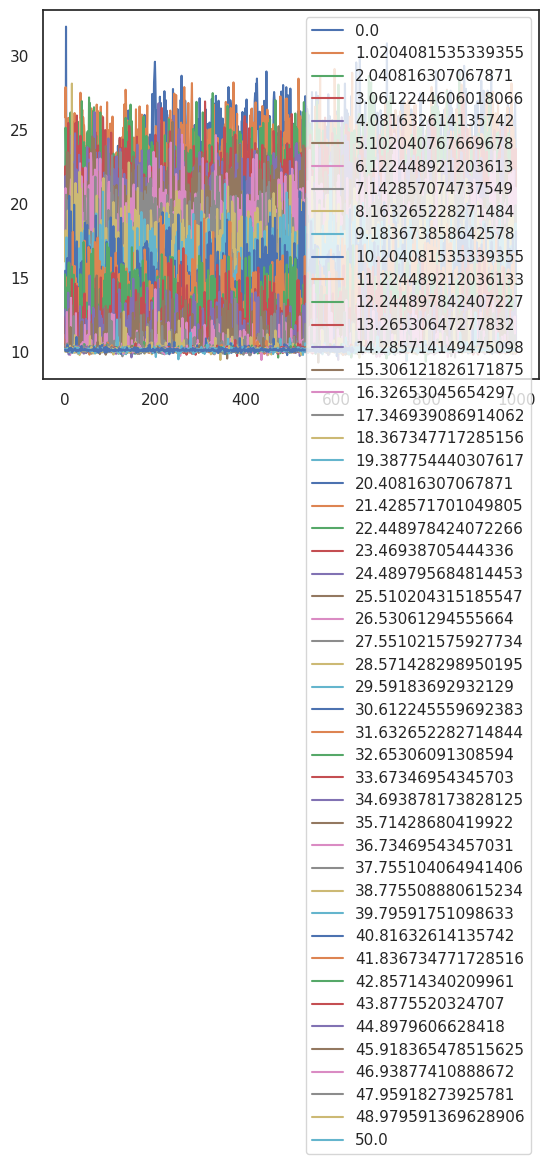

In [14]:
print(f"final kl: {kl_divergence_wrt_nominal}")
for epsilon in losses:
    plt.plot(losses[epsilon], label=epsilon)

plt.legend()

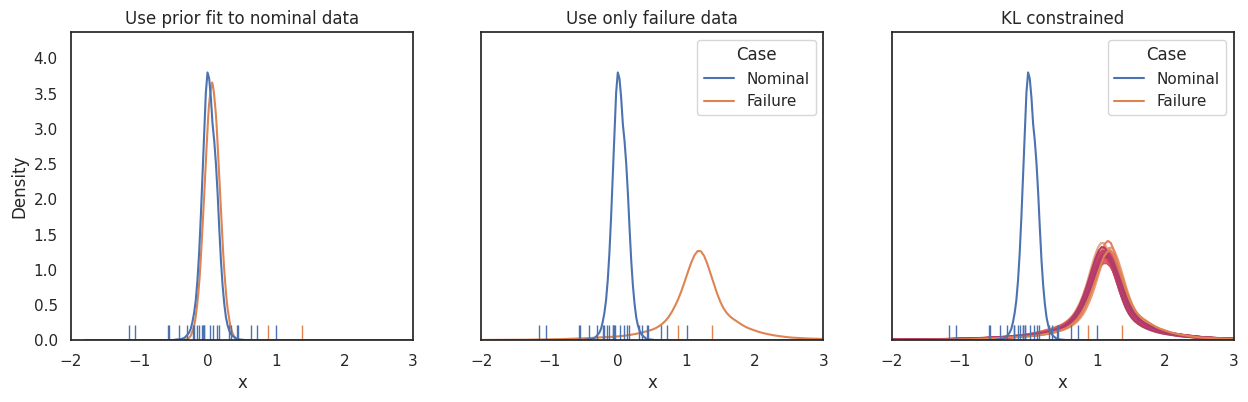

In [19]:
ax_names = [
    # "all_data",
    "nominal_prior",
    "failure_only",
    # "gavi",
    "kl_constrained",
]
fig, axs = plt.subplot_mosaic(
    [ax_names],
    figsize=(len(ax_names) * 5, 4),
    sharey=True,
)

# axs["all_data"].set_title("Use all data")
axs["failure_only"].set_title("Use only failure data")
axs["nominal_prior"].set_title("Use prior fit to nominal data")
# axs["gavi"].set_title("Graduated ELBO")
axs["kl_constrained"].set_title("KL constrained")

sns.kdeplot(
    data=failure_only_posterior_df,
    x="x",
    hue="Case",
    ax=axs["failure_only"],
    common_norm=False,
)
# sns.kdeplot(
#     data=all_posterior_df,
#     x="x",
#     hue="Case",
#     ax=axs["all_data"],
#     legend=False,
#     common_norm=False,
# )
sns.kdeplot(
    data=nominal_prior_df,
    x="x",
    hue="Case",
    ax=axs["nominal_prior"],
    legend=False,
    common_norm=False,
)

test_df = kl_constrained_flow_posterior_during_training_df.copy()
test_df["$\epsilon$"] = test_df["$\epsilon$"].astype(str)
sns.kdeplot(
    ax=axs["kl_constrained"],
    data=test_df,
    x="x",
    hue="$\epsilon$",
    legend=False,
    palette="flare_r",
    common_norm=False,
    hue_order=[str(x) for x in reversed(epsilons)],
)
sns.kdeplot(
    data=failure_only_posterior_df,
    x="x",
    hue="Case",
    ax=axs["kl_constrained"],
    common_norm=False,
)

for ax in axs.values():
    sns.rugplot(x="x", hue="type", data=df, ax=ax, legend=False, height=0.05)
    ax.set_xlim([-2, 3])

<Axes: xlabel='x', ylabel='Density'>

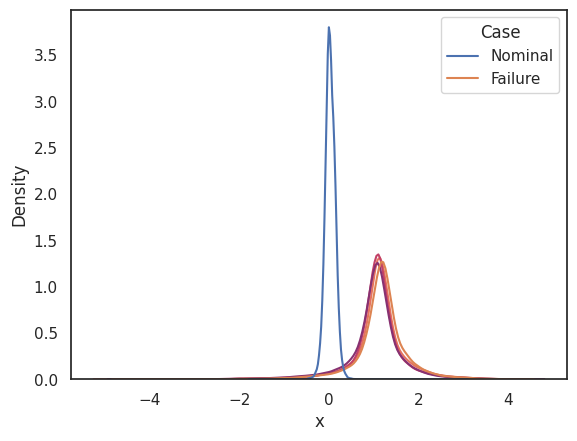

In [50]:
test_df = kl_constrained_flow_posterior_during_training_df.copy()
test_df["$\epsilon$"] = test_df["$\epsilon$"].astype(str)
ax = sns.kdeplot(
    data=test_df,
    x="x",
    hue="$\epsilon$",
    legend=False,
    palette="flare_r",
    common_norm=False,
    hue_order=[str(x) for x in reversed(epsilons)],
)

sns.kdeplot(data=failure_only_posterior_df, x="x", hue="Case", ax=ax, common_norm=False)

In [49]:
# Constraint: KL divergence w.r.t. nominal posterior KL(failure || nominal)
with param_store.scope(failure_flow_state):
    optim = torch.optim.Adam(failure_flow.parameters(), lr=0.01)
    for _ in range(100):
        optim.zero_grad()

        kl_divergence_wrt_nominal = torch.tensor(0.0)
        failure_dist = failure_flow(kl_constraint)
        nominal_dist = nominal_flow(kl_constraint)
        for _ in range(100):
            sample = failure_dist.sample()
            failure_guide_logprob = failure_dist.log_prob(sample)
            
            with param_store.scope(nominal_flow_state):
                nominal_guide_logprob = nominal_dist.log_prob(sample)

            kl_divergence_wrt_nominal = (
                kl_divergence_wrt_nominal
                + (failure_guide_logprob - nominal_guide_logprob) / 100
            )
        
        kl_divergence_wrt_nominal.backward()
        print(kl_divergence_wrt_nominal)
        print(list(failure_flow.parameters())[-1].grad.norm())
        optim.step()


tensor(17.7395, grad_fn=<AddBackward0>)
tensor(0.3199)
tensor(14.4268, grad_fn=<AddBackward0>)
tensor(0.4958)
tensor(12.1546, grad_fn=<AddBackward0>)
tensor(0.2677)
tensor(12.4153, grad_fn=<AddBackward0>)
tensor(0.2054)
tensor(11.6928, grad_fn=<AddBackward0>)
tensor(0.3490)
tensor(11.5758, grad_fn=<AddBackward0>)
tensor(0.3749)
tensor(12.1325, grad_fn=<AddBackward0>)
tensor(0.2765)
tensor(11.2457, grad_fn=<AddBackward0>)
tensor(0.3513)
tensor(11.7147, grad_fn=<AddBackward0>)
tensor(0.7117)
tensor(11.4062, grad_fn=<AddBackward0>)
tensor(0.4758)
tensor(12.8099, grad_fn=<AddBackward0>)
tensor(2.3494)
tensor(13.0058, grad_fn=<AddBackward0>)
tensor(0.2725)
tensor(12.9317, grad_fn=<AddBackward0>)
tensor(2.5588)
tensor(13.2224, grad_fn=<AddBackward0>)
tensor(1.9547)
tensor(15.4326, grad_fn=<AddBackward0>)
tensor(1.7727)
tensor(14.4353, grad_fn=<AddBackward0>)
tensor(2.1882)
tensor(13.4663, grad_fn=<AddBackward0>)
tensor(2.0714)
tensor(14.3551, grad_fn=<AddBackward0>)
tensor(0.9938)
tensor(14.

KeyboardInterrupt: 